# Introduction

Short notebook to get an overview of model performance across architectures and dimensionality.

Here we share some code to train a model from scratch and our procedure for evaluating and selecting models to study.

For each architecture (RNN, GRU, LSTM, NM-RNN) and dimensionality (1 or 2 hidden units) we fit a model to predict a subject's (WS16) choices during a 2-armed bandit task (75% reward probability at 'good poke' and 25% reward probability at the other poke). Note that in this data there are forced choice trials, but the loss associated with these predictions are excluded (since forced choices are random and cannot be predicted well).

All trials for a subject are split into train (80%), validation (10%), an evaluation (10%), seeded deterministically across models and repeated for 10 different seeds. 

Training is done with an early stop on validation prediction errors within each model type but across hyperparameters (varying sparsity). 

Then across models we compare performance on evaluation prediction errors. 

We then select the median performing model on the evaluation performance, so as not to overfit the transfer learning variability across splits.

We further study how these models predict the behaviour in the `mechanisms` notebook!

In [ ]:
## setup on google colab:

!git clone https://github.com/charlesdgburns/NM_TinyRNN.git
from pathlib import Path
CODE_DIR = Path('.')
SAVE_PATH = CODE_DIR/'NM_TinyRNN/data/rnns'
DATA_PATH = './NM_TinyRNN/data/AB_behaviour/WS16'


In [1]:
# local setup 

#may need to change directory to import the below
CODE_DIR = Path(r'C:\Users\owner\Research\NM_TinyRNN') #the directory containing NM_TinyRNN folder

import os
os.chdir(CODE_DIR.parent)

# there's multiple openMP processes on my local, 
# the following is an unsafe, unsupported, undocumented, workaround:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


NameError: name 'Path' is not defined

In [39]:
# general setup:

import json
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt


from NM_TinyRNN.code.models import training
from NM_TinyRNN.code.models import datasets
from NM_TinyRNN.code.models import rnns
from NM_TinyRNN.code.models import parallelised_training as pat
from importlib import reload

CODE_DIR =Path('.') #the directory containing NM_TinyRNN folder

SAVE_PATH = CODE_DIR/'NM_TinyRNN/data/rnns'
DATA_PATH = CODE_DIR/'NM_TinyRNN/data/AB_behaviour/WS16'


### Model training

Here we leave a bit of code to show how we train models, first one-by-one and then with a parallelised training approach (on a SLURM managed computing cluster).

In [62]:
# Train some models using the standard code
reload(training)
reload(datasets)
reload(rnns)


SEQUENCE_LENGTH = 150 # sequence length for batched training.

train_seed = 5
weight_seed = 5

options_dict = {'rnn_type':'GRU',
                'input_size':3,
                'hidden_size':2,
                'energy_lambda':1e-2,
                'nonlinearity':'relu',
                'input_encoding':'bipolar',
                'weight_seed':weight_seed}

dataset = datasets.AB_Dataset(DATA_PATH, SEQUENCE_LENGTH)
model = rnns.TinyRNN(**options_dict)  

trainer = training.Trainer(SAVE_PATH/'test',
                           batch_size = 8, 
                           max_epochs = 1000, 
                           early_stop = 200,
                           train_seed = train_seed,
                           sparsity_lambdas = [1e-5],
                           energy_lambdas = [1e-2],
                           weight_seeds = [5])
training_losses_df = trainer.fit(model,dataset)
# also get trials_df
trials_df = trainer.get_model_trial_by_trial_df(model,dataset)
trials_df

Starting training with 1 sparsity values...
Dataset size: 51
Split sizes - Train: 40, Validation: 5, Evaluation: 6

Training with 
 sparsity lambda = 1e-05, 
 weight seed = 5, 
 energy lambda = 0.01


λ=1e-05:  36%|███▋      | 363/1000 [02:40<04:42,  2.26it/s]

Early stopping after 364 epochs

Evaluating best model (sparsity = 1e-05, energy = 0.01, weight_seed = 5) on test set...
Evaluation loss: 0.465334

Training complete!
Best model (λ=1e-05) saved to: NM_TinyRNN/data/rnns/test
Best validation loss: 0.586137
Test loss: 0.465334
Lastly, extracting activations on full dataset


,hidden_1,hidden_2,gate_reset_1,gate_reset_2,gate_update_1,gate_update_2,logit_value,logit_past,logit_change,prob_A,...,forced_choice,choice,outcome,good_poke,session_trial_idx,session_folder_name,trial_type,indices_train,indices_validation,indices_evaluation
0,0.024438,0.0,0.768787,0.223073,0.162326,0.923730,0.738674,NaN,NaN,0.676706,...,1,0,1,1,0,2025-05-01-164959,"A1, R=1",True,False,False
1,0.038269,0.0,0.765887,0.225509,0.156766,0.924536,1.884971,0.738674,1.146297,0.868181,...,0,0,1,1,1,2025-05-01-164959,"A1, R=1",True,False,False
2,0.019086,0.0,0.499443,0.375851,0.296131,0.695262,0.820374,1.884971,-1.064597,0.694316,...,0,0,0,1,2,2025-05-01-164959,"A1, R=0",True,False,False
3,0.010447,0.0,0.502630,0.373276,0.302961,0.693346,0.196511,0.820374,-0.623863,0.548970,...,0,0,0,1,3,2025-05-01-164959,"A1, R=0",True,False,False
4,0.006250,0.0,0.512456,0.173585,0.598248,0.976777,-1.049024,0.196511,-1.245535,0.259412,...,1,1,1,1,4,2025-05-01-164959,"A2, R=1",True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7835,0.015440,0.0,0.509860,0.174874,0.591853,0.976943,-1.235357,0.783596,-2.018953,0.225245,...,0,1,1,1,444,2025-04-28-181702,"A2, R=1",False,False,False
7836,0.008775,0.0,0.503236,0.372788,0.304269,0.692980,-0.891109,-1.235357,0.344248,0.290881,...,1,0,0,1,445,2025-04-28-181702,"A1, R=0",False,False,False
7837,0.005256,0.0,0.512734,0.173447,0.598930,0.976759,-1.730095,-0.891109,-0.838986,0.150575,...,0,1,1,1,446,2025-04-28-181702,"A2, R=1",False,False,False
7838,0.004083,0.0,0.245088,0.300550,0.776806,0.885881,-1.208658,-1.730095,0.521438,0.229939,...,0,1,0,1,447,2025-04-28-181702,"A2, R=0",False,False,False


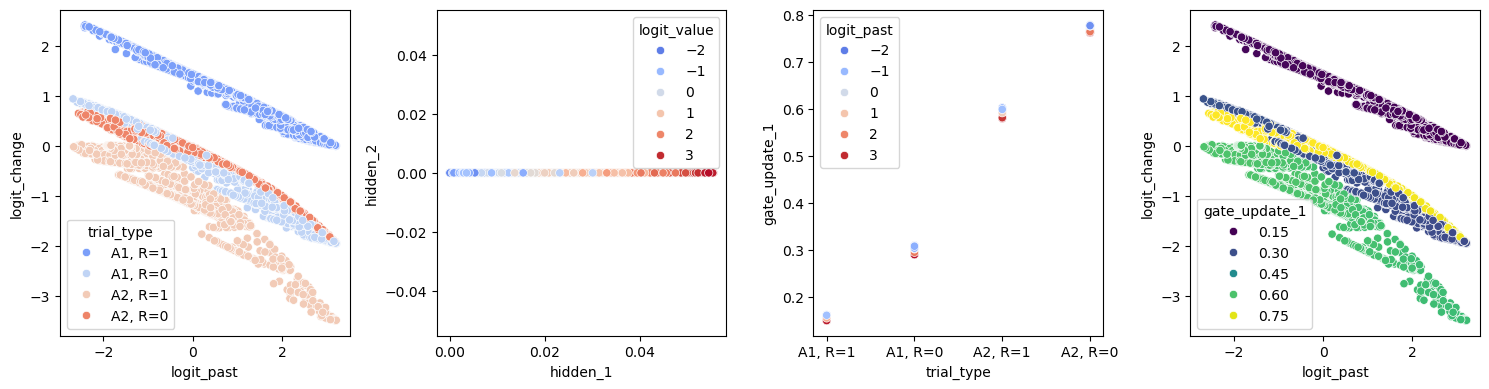

In [ ]:
fig, ax = plt.subplots(1,4, figsize = (15,4))

sns.scatterplot(trials_df,x='logit_past',y='logit_change', 
                hue = 'trial_type', palette='coolwarm', 
                ax= ax[0])
sns.scatterplot(trials_df, x='hidden_1', y='hidden_2', 
                hue = 'logit_value', palette='coolwarm', 
                ax = ax[1])
sns.scatterplot(trials_df, x='trial_type', y='gate_update_1', 
                hue = 'logit_past', palette='coolwarm', 
                ax = ax[2])
sns.scatterplot(trials_df, x='logit_past', y='logit_change', 
                hue = 'gate_update_1', palette='viridis', 
                ax = ax[3])

fig.tight_layout()

In [ ]:
#Gru plots
fig, ax  = plt.subplots(1,3, figsize = (12,4))
sns.scatterplot(trials_df, x='hidden_1', y='hidden_2', 
                hue = 'logit_value', palette='coolwarm', 
                ax = ax[0])
sns.scatterplot(trials_df, x='gate_update_1', y='gate_update_2',
                hue='trial_type',ax = ax[1])
sns.scatterplot(trials_df, x='gate_reset_1', y='gate_reset_2',
                hue = 'logit_past',ax = ax[2])
ax[1].set(xlim=[0,1], ylim=[0,1])
ax[2].set(xlim=[0,1], ylim=[0,1])

In [61]:
for name, param in model.named_parameters():
    print(name, param)

rnn.W_from_in Parameter containing:
tensor([[-0.5565, -0.7561,  0.4462],
        [ 0.7254,  0.1426, -0.7901]], requires_grad=True)
rnn.W_from_h Parameter containing:
tensor([[-1.0117, -1.2707, -0.8497]], requires_grad=True)
rnn.bias Parameter containing:
tensor([ 0.7707,  0.5197, -0.1584, -1.0729,  0.6256,  0.0848],
       requires_grad=True)
decoder.weight Parameter containing:
tensor([[ 2.5135],
        [-1.3930]], requires_grad=True)
decoder.bias Parameter containing:
tensor([-1.0287,  0.4423], requires_grad=True)


<Axes: xlabel='trial_type', ylabel='gate_update_1'>

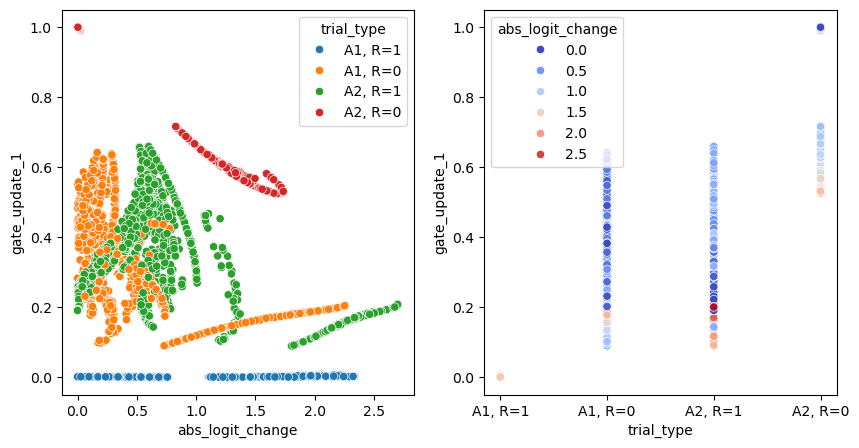

In [53]:
trials_df['abs_logit_change'] = trials_df['logit_change'].abs()
fig, ax = plt.subplots(1,2, figsize = (10,5))
sns.scatterplot(trials_df,x='abs_logit_change',
                y='gate_update_1',
                hue = 'trial_type',
                ax = ax[0])
sns.scatterplot(trials_df, x='trial_type', y='gate_update_1', 
                hue = 'abs_logit_change', palette='coolwarm', 
                ax = ax[1])

trial_type
A1, R=0    Axes(0.125,0.11;0.775x0.77)
A1, R=1    Axes(0.125,0.11;0.775x0.77)
A2, R=0    Axes(0.125,0.11;0.775x0.77)
A2, R=1    Axes(0.125,0.11;0.775x0.77)
Name: gate_update_1, dtype: object

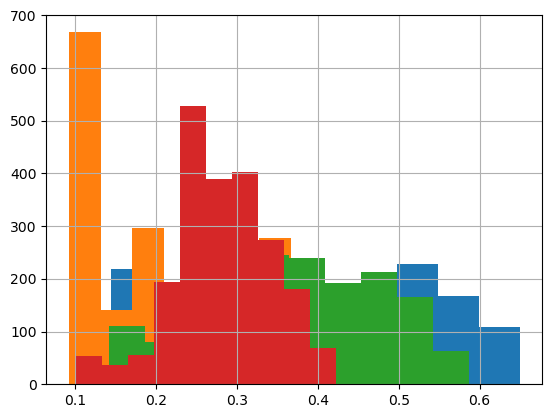

In [36]:
trials_df.groupby('trial_type').gate_update_1.hist()

In [38]:
# you can train a bunch of models with pat:

reload(pat)
pat.run_training(overwrite=True) #OBS: this will send jobs ot the cluster !
#pat.get_train_info_df()

NM_TinyRNN/data/AB_behaviour/README.md
NM_TinyRNN/data/AB_behaviour/WS18
NM_TinyRNN/data/AB_behaviour/WS16
Submitting model training for WS18 to HPC
Submitted batch job 1312000
Submitting model training for WS18 to HPC
Submitted batch job 1312001
Submitting model training for WS18 to HPC
Submitted batch job 1312002
Submitting model training for WS18 to HPC
Submitted batch job 1312003
Submitting model training for WS18 to HPC
Submitted batch job 1312004
Submitting model training for WS18 to HPC
Submitted batch job 1312005
Submitting model training for WS18 to HPC
Submitted batch job 1312006
Submitting model training for WS18 to HPC
Submitted batch job 1312007
Submitting model training for WS18 to HPC
Submitted batch job 1312008
Submitting model training for WS18 to HPC
Submitted batch job 1312009
Submitting model training for WS18 to HPC
Submitted batch job 1312010
Submitting model training for WS18 to HPC
Submitted batch job 1312011
Submitting model training for WS18 to HPC
Submitted b

In [551]:
for subdir in Path('./NM_TinyRNN/data/AB_behaviour').iterdir():
    print(subdir)

NM_TinyRNN/data/AB_behaviour/README.md
NM_TinyRNN/data/AB_behaviour/WS18
NM_TinyRNN/data/AB_behaviour/WS16


### Model performance and selection

Models are trained on 80% training data, with early stopping on 10% validation data, before computing a performance score on the last 10% evaluation data.

We do this with 10 random seeds and select the median performing model, for each architecture, in order to avoid overfitting on the data splits.

These 'median' models are then investigated further.

In [487]:
# you've trained a bunch of models with pat
#Here we append the evaluation performance to the model info dataframe

info_df = pat.get_train_info_df()
evals = []
seeds = []
for model_info in info_df.itertuples():
    model_dir = Path(model_info.save_path)
    eval_json_path = model_dir / f'{model_info.model_id}_info.json'
    if eval_json_path.exists():
        with open(eval_json_path, 'r') as f:
            eval_info = json.load(f)
        evals.append(eval_info['eval_pred_loss'])
    else:
        evals.append(np.nan)
info_df['eval_CE'] = evals
#open the json and extract eval performance for each model:

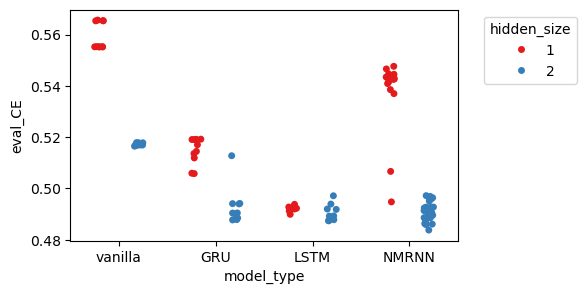

In [5]:
#Plot model performance across seeds and architectures:

plt.figure(figsize=(5,3))
ax = sns.stripplot(
    data=info_df,  
    y='eval_CE', 
    x='model_type',
    hue='hidden_size',
    jitter=True,
    dodge=True, palette='Set1',
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='hidden_size')
plt.show()

In [10]:
info_df.groupby("model_id").min("eval_CE")

,hidden_size,nm_size,nm_dim,completed,eval_CE
model_id,,,,,
1_unit_GRU,1,1,1,True,0.505787
1_unit_LSTM,1,1,1,True,0.489911
1_unit_NMRNN_1_subunits_1_low_rank,1,1,1,True,0.538541
1_unit_NMRNN_2_subunits_1_low_rank,1,2,1,True,0.494762
1_unit_vanilla,1,1,1,True,0.555176
2_unit_GRU,2,1,1,True,0.487723
2_unit_LSTM,2,1,1,True,0.487404
2_unit_NMRNN_1_subunits_1_low_rank,2,1,1,True,0.491363
2_unit_NMRNN_1_subunits_2_low_rank,2,1,2,True,0.486280


In [11]:
## Code to get 'median_df' and copy over the median-performing models for testing and comparisons

def closest_to_median(subdf):
    med = subdf["eval_CE"].median()
    idx = (subdf["eval_CE"] - med).abs().idxmin()
    return subdf.loc[idx, :]

median_df = info_df.groupby("model_id").apply(closest_to_median).reset_index(drop=True)
median_df

def idx_min(subdf):
    min = subdf["eval_CE"].min()
    idx = (subdf["eval_CE"] - min).abs().idxmin()
    return subdf.loc[idx, :]

min_df = info_df.groupby("model_id").apply(idx_min).reset_index(drop=True)

import os
import shutil
from pathlib import Path

def copy_median_models(df, example_path):
    """
    Copy median performing model files into EXAMPLE_PATH/<model_type>/.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns ['save_path', 'model_type', 'model_ID'].
        save_path should be a pathlib.Path pointing to the model directory.
    example_path : str or Path
        Parent directory where copies will be stored.
    """
    example_path = Path(example_path)
    example_path.mkdir(parents=True, exist_ok=True)

    # files we want to copy for each model
    file_suffixes = [
        "_info.json",
        "_model_state.pth",
        "_training_losses.htsv",
        "_trials_data.htsv",
    ]
    
    for _, row in df.iterrows():
        save_path = Path(row["save_path"])
        model_type = row["model_type"]
        model_id = row["model_id"]

        # make sure destination subfolder exists
        dest_dir = example_path / model_type
        dest_dir.mkdir(parents=True, exist_ok=True)

        for suffix in file_suffixes:
            src = save_path / f"{model_id}{suffix}"
            dst = dest_dir / f"{model_id}{suffix}"
            if src.exists():
                shutil.copy(src, dst)
                print(f"Copied {src} → {dst}")
            else:
                print(f"Warning: {src} not found!")

# Example usage:
copy_median_models(min_df, Path('./NM_TinyRNN/data/rnns/example'))


/tmp/ipykernel_20669/1545226274.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  median_df = info_df.groupby("model_id").apply(closest_to_median).reset_index(drop=True)
/tmp/ipykernel_20669/1545226274.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_df = info_df.groupby("model_id").apply(idx_min).reset_index(drop=True)


Copied NM_TinyRNN/data/rnns/WS16/random_seed_10/GRU/1_unit_GRU_info.json → NM_TinyRNN/data/rnns/example/GRU/1_unit_GRU_info.json
Copied NM_TinyRNN/data/rnns/WS16/random_seed_10/GRU/1_unit_GRU_model_state.pth → NM_TinyRNN/data/rnns/example/GRU/1_unit_GRU_model_state.pth
Copied NM_TinyRNN/data/rnns/WS16/random_seed_10/GRU/1_unit_GRU_training_losses.htsv → NM_TinyRNN/data/rnns/example/GRU/1_unit_GRU_training_losses.htsv
Copied NM_TinyRNN/data/rnns/WS16/random_seed_10/GRU/1_unit_GRU_trials_data.htsv → NM_TinyRNN/data/rnns/example/GRU/1_unit_GRU_trials_data.htsv
Copied NM_TinyRNN/data/rnns/WS16/random_seed_8/LSTM/1_unit_LSTM_info.json → NM_TinyRNN/data/rnns/example/LSTM/1_unit_LSTM_info.json
Copied NM_TinyRNN/data/rnns/WS16/random_seed_8/LSTM/1_unit_LSTM_model_state.pth → NM_TinyRNN/data/rnns/example/LSTM/1_unit_LSTM_model_state.pth
Copied NM_TinyRNN/data/rnns/WS16/random_seed_8/LSTM/1_unit_LSTM_training_losses.htsv → NM_TinyRNN/data/rnns/example/LSTM/1_unit_LSTM_training_losses.htsv
Copied